In [1]:
%matplotlib inline

from collections import defaultdict
from datetime import datetime
import math
import os

import matplotlib.pyplot as plt
import pandas as pd
import tldextract
from cryptography import x509
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import hashes

from pyspark.errors import *
from pyspark.sql.types import TimestampType, StringType, ArrayType, IntegerType, BooleanType, StructField, StructType
import pyspark.sql.functions as psf
from pyspark.storagelevel import StorageLevel

In [42]:
%run ./spark-instance-gustavo.ipynb

SparkConf created
Started SparkSession
Spark version 3.5.0


In [41]:
clean_spark()

In [3]:
from ip_as_org import IPASnPrefix, ASOrg

def get_ip_asn_as_org_obj(timestamps):
    dates = [ts.strftime("%Y%m%d") for ts in timestamps]
    dataset_dir = "../dataset/"
    ip_asn = IPASnPrefix(dates, dataset_dir)
    as_org = ASOrg(dates, dataset_dir)
    return ip_asn, as_org

def ip_to_country(ip: str, when: str) -> str:
    asn = ip_asn.get_asn_from_ip(ip, when)
    if asn is None:
        return "Unknown"
    try:
        country = as_org.get_country_from_asn(asn, when)
    except ValueError:
        country = "Unknown"
    return country

def ip_to_org(ip: str, when: str) -> str:
    asn = ip_asn.get_asn_from_ip(ip, when)
    if asn is None:
        return "Unknown"
    try:
        org = as_org.get_org_name_from_asn(asn, when)
    except ValueError:
        org = "Unknown"
    return org


ip_to_country_udf = psf.udf(ip_to_country, StringType())
ip_to_org_udf = psf.udf(ip_to_org, StringType())

### Extracting Goscanner data

In [20]:
def eval_list_list_str(my_list):
    try:
        if isinstance(my_list, str):
            return eval(my_list)
        else:
            return [[]]
    except:
        return [[]]


eval_list_list_str_udf = psf.udf(eval_list_list_str, ArrayType(ArrayType(StringType())))


def eval_list(my_list):
    try:
        if isinstance(my_list, str):
            return eval(my_list)
        else:
            return []
    except:
        return []


eval_udf = psf.udf(eval_list, ArrayType(IntegerType()))


def load_hosts_data(port, ts):
    hosts_base_path = HOSTS_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    hosts_df = spark.read.option("header", "true") \
                         .option("lineSep", "\n") \
                         .option("quote", "\"") \
                         .option("escape", "\"") \
                         .option("inferSchema", "true") \
                         .csv(f"../dataset/{hosts_base_path}")
    return hosts_df


def load_certs_data(port, ts):
    certs_base_path = CERTS_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    certs_df = spark.read.option("header", "true") \
                         .option("multiline", "true") \
                         .option("wholeFile", "true") \
                         .option("inferSchema", "true") \
                         .csv(f"../dataset/{certs_base_path}")
    return certs_df


def load_tls_data(port, ts):
    tls_base_path = TLS_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    tls_df = spark.read.option("header", "true") \
                       .option("multiline", "true") \
                       .option("wholeFile", "true") \
                       .option("inferSchema", "true") \
                       .csv(f"../dataset/{tls_base_path}")
    return tls_df


def load_ldap_data(port, ts):
    ldap_base_path = LDAP_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    ldap_df = spark.read.option("header", "true") \
                        .option("lineSep", "\n") \
                        .option("quote", "\"") \
                        .option("escape", "\"") \
                        .option("inferSchema", "true") \
                        .csv(f"../dataset/{ldap_base_path}")
    return ldap_df


def load_ldapstarttls_data(port, ts):
    starttls_base_path = STARTTLS_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    starttls_df = spark.read.option("header", "true") \
                            .option("lineSep", "\n") \
                            .option("quote", "\"") \
                            .option("escape", "\"") \
                            .option("inferSchema", "true") \
                            .csv(f"../dataset/{starttls_base_path}")
    return starttls_df


def load_cert_validator(port, ts):
    cert_validator_base_path = CERTVAL_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    df = spark.read.option("basePath", f"../dataset/{cert_validator_base_path}")\
                   .parquet(f"../dataset/{cert_validator_base_path}")
    return df


def convert_output_df(df):
    df = df.select("id", "generic_error", psf.explode("root_stores").alias("store_name", "result"))
    df = df.select("id", "generic_error", "store_name", "result.*")
    df = df.withColumn("vc", eval_list_list_str_udf(psf.col("valid_chains")))
    df = df.drop("valid_chains")
    df = df.withColumnRenamed("vc", "valid_chains")
    return df


len_udf = psf.udf(lambda chain: [len(x) for x in chain], ArrayType(IntegerType()))


def chain_len(df):
    df = df.withColumn("chain_len", len_udf(psf.col("valid_chains")))
    df.select("chain_len").groupBy(psf.col("chain_len")).count().show()
    return df


SHORT1 = "Unknown authority"
SHORT2 = "Expired/Not yet valid"
SHORT3 = "Not authorized"
SHORT4 = "Too many intermediates"
SHORT5 = "Bad extension"
SHORT6 = "Other errors"
SHORT7 = "Self-signed"


short_error_name_map = {
    'x509: certificate signed by unknown authority': SHORT1,
    'x509: certificate signed by unknown authority - With possible explanation': SHORT1,
    'x509: certificate has expired or is not yet valid': SHORT2,
    'x509: certificate is not authorized to sign other certificates': SHORT3,
    'x509: too many intermediates for path length constraint': SHORT4,
    'x509: unhandled critical extension': SHORT5
}


def peer_certs_len(peer_certs_str):
    peer_certs = eval_list(peer_certs_str)
    return len(peer_certs)


peer_certs_len_udf = psf.udf(peer_certs_len, IntegerType())


def parse_error(error_data):
    if error_data == "":
        return ""
    # magic
    parsed_error_data = ':'.join(error_data.split(":")[:2])
    if "possibly because" in error_data:
        parsed_error_data = parsed_error_data.split("(")[0] + "- With possible explanation"
    return parsed_error_data


parse_error_udf = psf.udf(parse_error, StringType())


def error_str(error_list, peer_certs_len_list):
    for i in range(len(error_list)):
        parsed_error = parse_error(error_list[i])
        if "certificate signed by unknown authority" in parsed_error:
            if peer_certs_len_list == 1:
                return SHORT7

    for error in error_list:
        if error != "":
            parsed_error = parse_error(error)
            return short_error_name_map[parsed_error]
    return ""

error_str_udf = psf.udf(error_str, StringType())


# port 636 scans occurs one day earlier than port 389
PORT_SCANDATE_MAP = {
    636: [
        datetime(2023, 11, 7),
        datetime(2023, 11, 14),
        datetime(2023, 11, 21),
        datetime(2023, 11, 28)
    ],
    389: [
        datetime(2023, 11, 1),
        datetime(2023, 11, 8),
        datetime(2023, 11, 15),
        datetime(2023, 11, 22),
        datetime(2023, 11, 29)
    ]
}

HOSTS_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=tcp/result=hosts/year={year}/month={month:02d}/day={day:02d}"
CERTS_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=tls/result=certs/year={year}/month={month:02d}/day={day:02d}"
TLS_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=tls/result=tls_verbose/year={year}/month={month:02d}/day={day:02d}"
LDAP_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=ldap/result=ldap/year={year}/month={month:02d}/day={day:02d}"
STARTTLS_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=starttls_ldap/result=starttls_ldap/year={year}/month={month:02d}/day={day:02d}"
CERTVAL_PATH_FMT = "catrin/data_processing/tool=cert-validator/format=parquet/port={port}/year={year}/month={month:02d}/day={day:02d}"


goscanner_timestamps = []
for dates in PORT_SCANDATE_MAP.values():
    goscanner_timestamps.extend(dates)


ip_asn, as_org = get_ip_asn_as_org_obj(goscanner_timestamps)


tls_version_str_dict = {
    int("0x0301", 16): "TLSv1.0",
    int("0x0302", 16): "TLSv1.1",
    int("0x0303", 16): "TLSv1.2",
    int("0x0304", 16): "TLSv1.3",
    int("0x0300", 16): "SSLv3"
}


def tls_version_to_string(version_number: int):
    return tls_version_str_dict.get(version_number, str(version_number))


tls_version_udf = psf.udf(tls_version_to_string, StringType())


def convert_cipher(x):
    try:
        parts = [int(part, 16) for part in x.split(",")]
    except ValueError:
        # to cover reserved values like 0x00,0x1C-1D
        return None
    cipher = parts[0] << 8
    cipher |= parts[1]
    return hex(cipher)[2:]


# https://www.iana.org/assignments/tls-parameters/tls-parameters.xhtml#tls-parameters-4
tls_parameters_pdf = pd.read_csv("tls-parameters-4.csv")
tls_parameters_pdf["Cipher"] = tls_parameters_pdf["Value"].apply(convert_cipher)
tls_parameters_pdf["DTLS-OK"] = tls_parameters_pdf["DTLS-OK"].apply(lambda x: str(x))
tls_parameters_pdf["Recommended"] = tls_parameters_pdf["Recommended"].apply(lambda x: str(x))
tls_parameters_pdf["Reference"] = tls_parameters_pdf["Reference"].apply(lambda x: str(x))
tls_parameter_dict = tls_parameters_pdf[["Cipher", "Description"]].set_index("Cipher").to_dict()["Description"]


def cipher_to_description(cipher):
    return tls_parameter_dict.get(cipher, "Unknown")


cipher_to_description_udf = psf.udf(cipher_to_description, StringType())

In [5]:
# Decoding X.509 certificates
def get_x509(pem: str):
    return x509.load_pem_x509_certificate(str.encode(pem), default_backend())


def get_extensions(cert):
    tls_key_exchange = []
    san_list = []
    try:
        extensions = cert.extensions
        for extension in extensions:
            if isinstance(extension.value, x509.TLSFeature):
                tls_key_exchange.append(extension.value.key_exchange)
                continue
            if isinstance(extension.value, x509.SubjectAlternativeName):
                subject_alt_name = extension.value
                san_list += [name for name in subject_alt_name.get_values_for_type(x509.DNSName)]
                continue
    except:
        pass

    return tls_key_exchange, san_list


def get_x509_fields(pem: str):
    try:
        cert = get_x509(pem)
    except ValueError:
        # the certificate contains bytes that cannot be interpreted. Probably invalid cert
        # https://github.com/pyca/cryptography/issues/6804
        print(pem)
        return 4 * [None]  # CHANGE HERE IN CASE ADDITIONAL RETURN PARAMETER

    _, san_list = get_extensions(cert)

    public_key_size = None
    try:
        public_key_size = cert.public_key().key_size
    except AttributeError:
        #'cryptography.hazmat.bindings._rust.openssl.ed25519' object has no attribute 'key_size'
        pass

    cert_fp = cert.fingerprint(hashes.SHA256()).hex().upper()

    return (cert.signature_algorithm_oid._name,
            public_key_size,
            san_list,
            cert_fp,
           )


pem_decoded_schema = StructType([StructField("tls_signature_algorithm", StringType(), True),
                                 StructField("pubkey_bit_size", IntegerType(), True),
                                 StructField("leaf_data_names", ArrayType(StringType()), True),  # SAN
                                 StructField("fingerprint", StringType(), True),
                                ])


decode_cert_udf = psf.udf(get_x509_fields, pem_decoded_schema)

In [43]:
# data extracted using different notebook (ldap-dependency-goscanner-data-preparation.ipynb).
goscanner_df = spark.read.parquet(f"../dataset/catrin/ldap-dependency-goscanner.parquet")

goscanner_df = goscanner_df.withColumn("country", ip_to_country_udf(psf.col("ipv4"), psf.col("date")))
goscanner_df = goscanner_df.withColumn("org", ip_to_org_udf(psf.col("ipv4"), psf.col("date")))

self_signed_udf = psf.udf(lambda error_str: error_str == SHORT7, BooleanType())
goscanner_df = goscanner_df.withColumn("error", error_str_udf(psf.col("root_store_error_list"), psf.col("peer_certs_len")))
goscanner_df = goscanner_df.withColumn("tls_signature_self_signed", self_signed_udf(psf.col("error")))

### Extracting Censys data

In [26]:
DATASET = "universal-internet-dataset"
CENSYS_BASE_PATH_FMT = "censys/dataset={dataset}/format=parquet"
CENSYS_PATH_FMT = os.path.join(CENSYS_BASE_PATH_FMT, "year={year}/month={month:02d}/day={day:02d}")

# Censys snapshot of 2022-Nov
timestamps = [
    datetime(2022, 11, 1),
    datetime(2022, 11, 8),
    datetime(2022, 11, 15),
    datetime(2022, 11, 22),
    datetime(2022, 11, 29),
]


def load_censys_data(ts):
    censys_base_path = CENSYS_PATH_FMT.format(dataset=DATASET, year=ts.year, month=ts.month, day=ts.day)
    try:
        censys_df = spark.read.option("basePath", f"../dataset/{censys_base_path}").parquet(f"../dataset/{censys_base_path}")
    except AnalysisException as e:
        print(e)
    return censys_df


def filter_df_by_label(df, ts, label: str):
    llabel = label.lower()

    ser_filtered_df = df.select('*').where((psf.array_contains(psf.col("service_names_list"), label.upper())))
    ser_filtered_df = ser_filtered_df.withColumn("filter_source", psf.lit("service_name"))

    if False:
        dns_filtered_df = df.select('*').filter(
            (psf.expr(f"exists(dns_names, x -> lower(x) like '%.{llabel}.%') or exists(dns_names, x -> lower(x) like '{llabel}.%')")) | 
            (psf.expr(f"exists(r_dns_names, x -> lower(x) like '%.{llabel}.%') or exists(r_dns_names, x -> lower(x) like '{llabel}.%')"))
        )
        dns_filtered_df = dns_filtered_df.withColumn("filter_source", psf.lit("dns_rdns"))

        filtered_df = ser_filtered_df.unionByName(dns_filtered_df)
        uniq_filtered_df = filtered_df.dropDuplicates(["ipv4"])
        uniq_filtered_df = uniq_filtered_df.withColumn("date", psf.lit(ts).cast(TimestampType()))

    return ser_filtered_df

ip_asn, as_org = get_ip_asn_as_org_obj(timestamps)

In [44]:
CENSYS_TS_DICT = {}
for ts in timestamps:
    print(ts)
    _censys_df = load_censys_data(ts)

    select_df = _censys_df.select("host_identifier.ipv4",
                                 _censys_df.dns.names.alias("dns_names"),
                                 _censys_df.dns.reverse_dns.names.alias("r_dns_names"),
                                 "service_names_list",
                                 "services.port",
                                 _censys_df.services.tls.certificates.leaf_data.names.alias("leaf_data_names"),
                                 _censys_df.services.tls.version_selected.alias("tls_version"),
                                 _censys_df.services.tls.cipher_selected.alias("tls_cipher"),
                                 "services.tls.certificates.leaf_data.pubkey_bit_size",
                                 _censys_df.services.tls.certificates.leaf_data.signature.self_signed.alias("tls_signature_self_signed"),
                                 _censys_df.services.tls.certificates.leaf_data.signature.signature_algorithm.alias("tls_signature_algorithm"),
                                 _censys_df.services.tls.certificates.leaf_data.subject.common_name.alias("cert_cn"),
                                 _censys_df.services.tls.certificates.leaf_data.issuer.common_name.alias("issuer_cn")
                                )

    uniq_filtered_df = filter_df_by_label(select_df, ts, "ldap")

    when = ts.strftime("%Y%m%d")
    uniq_filtered_df = uniq_filtered_df.withColumn("country", ip_to_country_udf(psf.col("ipv4"), psf.lit(when)))
    uniq_filtered_df = uniq_filtered_df.withColumn("org", ip_to_org_udf(psf.col("ipv4"), psf.lit(when)))
    uniq_filtered_df = uniq_filtered_df.withColumn("date", psf.lit(ts).cast(TimestampType()))

    CENSYS_TS_DICT[ts] = uniq_filtered_df
print("-------")

2022-11-01 00:00:00
2022-11-08 00:00:00
2022-11-15 00:00:00
2022-11-22 00:00:00
2022-11-29 00:00:00
-------


In [45]:
try:
    censys_compact_df.unpersist()
except:
    pass

dfs = [df for df in CENSYS_TS_DICT.values()]

censys_compact_df = dfs[0].unionByName(dfs[1])
for i in range(2, len(dfs)):
    censys_compact_df = censys_compact_df.unionByName(dfs[i])

censys_compact_df.persist()

DataFrame[ipv4: string, dns_names: array<string>, r_dns_names: array<string>, service_names_list: array<string>, port: array<bigint>, leaf_data_names: array<array<string>>, tls_version: array<string>, tls_cipher: array<string>, pubkey_bit_size: array<int>, tls_signature_self_signed: array<boolean>, tls_signature_algorithm: array<string>, cert_cn: array<array<string>>, issuer_cn: array<array<string>>, filter_source: string, country: string, org: string, date: timestamp]

#### Why not use Censys organization and country information?

In [182]:
# NOT REQUIRED TO RUN!
load_censys_data(ts).select("host_identifier.ipv4", "autonomous_system.organization", "autonomous_system.country_code").filter(psf.col("organization").isNotNull()).show()
censys_compact_df.select("ipv4", "org", "country", "date").filter(psf.col("date") == ts).show(3)

+----+------------+------------+
|ipv4|organization|country_code|
+----+------------+------------+
+----+------------+------------+

+-------------+--------------------+-------+-------------------+
|         ipv4|                 org|country|               date|
+-------------+--------------------+-------+-------------------+
|189.230.16.99| Uninet S.A. de C.V.|     MX|2022-11-29 00:00:00|
|182.23.45.228|Network Access Pr...|     ID|2022-11-29 00:00:00|
|220.130.83.30|Chunghwa Telecom ...|     TW|2022-11-29 00:00:00|
+-------------+--------------------+-------+-------------------+
only showing top 3 rows



In [46]:
dfs = []
for df in CENSYS_TS_DICT.values():
    df2 = df.select("ipv4", "filter_source", "date", "country", "org",
                    psf.explode_outer(psf.arrays_zip(
                                        df.dns_names.alias("dns_name"),
                                        df.r_dns_names.alias("r_dns_name"),
                                        df.leaf_data_names.alias("leaf_data_name"),
                                        df.service_names_list.alias("service_name"),
                                        df.port.alias("port"),
                                        df.tls_version,
                                        df.tls_cipher,
                                        df.pubkey_bit_size,
                                        df.tls_signature_self_signed,
                                        df.tls_signature_algorithm,
                                        df.cert_cn,
                                        df.issuer_cn)))
    df2 = df2.select("ipv4", "filter_source", "date", "country", "org",
                     "col.dns_name", "col.r_dns_name", "col.leaf_data_name", "col.service_name", "col.port", "col.tls_version",
                     "col.tls_cipher", "col.pubkey_bit_size", "col.tls_signature_self_signed",
                     "col.tls_signature_algorithm", "col.cert_cn", "col.issuer_cn")

    # look these examples. There are 2 LDAP services for the same IP, there is ldap0.acc.umu.se in the dns_names, dns_names with one element (first) mapps to the first service name (probably right?)
    #df.filter((psf.col("ipv4") == "100.18.51.128") | (psf.col("ipv4") == "100.37.175.222") | (psf.col("ipv4") == "116.203.25.90") | (psf.col("ipv4") == "130.239.18.143")).select("ipv4", "filter_source", "dns_names", "service_names_list", "cert_cn").show(truncate=False)
    #df2.filter((psf.col("ipv4") == "100.18.51.128") | (psf.col("ipv4") == "100.37.175.222") | (psf.col("ipv4") == "116.203.25.90") | (psf.col("ipv4") == "130.239.18.143")).select("ipv4", "filter_source", "dns_name", "service_name", "cert_cn").show(truncate=False)

    if False:
        df2_filtered = df2.filter((psf.col("dns_name").like("%.ldap.%")) | (psf.col("dns_name").like("ldap.%")) | (psf.col("r_dns_name").like("%.ldap.%")) | (psf.col("r_dns_name").like("ldap.%")) | (psf.col("service_name") == "LDAP"))
    df2_filtered = df2.filter(psf.col("service_name") == "LDAP")

    #display(df2_filtered.count())  # 94997
    #display(df2_filtered.dropDuplicates(["ipv4"]).count())  # 74824
    dfs.append(df2_filtered)

censys_df = dfs[0].unionByName(dfs[1])
for i in range(2, len(dfs)):
    censys_df = censys_df.unionByName(dfs[i])

### Hosts analysis

In [80]:
def process_hosts(df, dataset: str):
    df.persist()

    print("Processing LDAP hosters")
    ldap_hoster_pdf = df.select("ipv4", "date").groupBy("date").count().coalesce(1).pandas_api()
    ldap_hoster_pdf.to_csv(f"../dataset/processing/{dataset}_date_ldap_hosts")

    df.unpersist()

In [82]:
print("Processing Censys CUIDS")
process_hosts(censys_df, "censys")

print("Processing GoScanner")
process_hosts(goscanner_df, "goscanner")

Processing Censys CUIDS
Processing LDAP hosters


/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Py4JJavaError: An error occurred while calling o3441.save.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 18.0 failed 1 times, most recent failure: Lost task 0.0 in stage 18.0 (TID 371) (ldap-dependency-code executor driver): java.io.IOException: org.apache.spark.SparkException: [INTERNAL_ERROR_BROADCAST] Failed to get broadcast_12_piece21 of broadcast_12
	at org.apache.spark.util.SparkErrorUtils.tryOrIOException(SparkErrorUtils.scala:42)
	at org.apache.spark.util.SparkErrorUtils.tryOrIOException$(SparkErrorUtils.scala:33)
	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:94)
	at org.apache.spark.broadcast.TorrentBroadcast.readBroadcastBlock(TorrentBroadcast.scala:252)
	at org.apache.spark.broadcast.TorrentBroadcast.getValue(TorrentBroadcast.scala:109)
	at org.apache.spark.broadcast.Broadcast.value(Broadcast.scala:70)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$22(PythonRunner.scala:442)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:438)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)
Caused by: org.apache.spark.SparkException: [INTERNAL_ERROR_BROADCAST] Failed to get broadcast_12_piece21 of broadcast_12
	at org.apache.spark.SparkException$.internalError(SparkException.scala:92)
	at org.apache.spark.SparkException$.internalError(SparkException.scala:100)
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$readBlocks$1(TorrentBroadcast.scala:223)
	at scala.runtime.java8.JFunction1$mcVI$sp.apply(JFunction1$mcVI$sp.java:23)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.broadcast.TorrentBroadcast.readBlocks(TorrentBroadcast.scala:192)
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$readBroadcastBlock$4(TorrentBroadcast.scala:281)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$readBroadcastBlock$2(TorrentBroadcast.scala:257)
	at org.apache.spark.util.KeyLock.withLock(KeyLock.scala:64)
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$readBroadcastBlock$1(TorrentBroadcast.scala:252)
	at org.apache.spark.util.SparkErrorUtils.tryOrIOException(SparkErrorUtils.scala:35)
	... 15 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.io.IOException: org.apache.spark.SparkException: [INTERNAL_ERROR_BROADCAST] Failed to get broadcast_12_piece21 of broadcast_12
	at org.apache.spark.util.SparkErrorUtils.tryOrIOException(SparkErrorUtils.scala:42)
	at org.apache.spark.util.SparkErrorUtils.tryOrIOException$(SparkErrorUtils.scala:33)
	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:94)
	at org.apache.spark.broadcast.TorrentBroadcast.readBroadcastBlock(TorrentBroadcast.scala:252)
	at org.apache.spark.broadcast.TorrentBroadcast.getValue(TorrentBroadcast.scala:109)
	at org.apache.spark.broadcast.Broadcast.value(Broadcast.scala:70)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$22(PythonRunner.scala:442)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:438)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)
Caused by: org.apache.spark.SparkException: [INTERNAL_ERROR_BROADCAST] Failed to get broadcast_12_piece21 of broadcast_12
	at org.apache.spark.SparkException$.internalError(SparkException.scala:92)
	at org.apache.spark.SparkException$.internalError(SparkException.scala:100)
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$readBlocks$1(TorrentBroadcast.scala:223)
	at scala.runtime.java8.JFunction1$mcVI$sp.apply(JFunction1$mcVI$sp.java:23)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.broadcast.TorrentBroadcast.readBlocks(TorrentBroadcast.scala:192)
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$readBroadcastBlock$4(TorrentBroadcast.scala:281)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$readBroadcastBlock$2(TorrentBroadcast.scala:257)
	at org.apache.spark.util.KeyLock.withLock(KeyLock.scala:64)
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$readBroadcastBlock$1(TorrentBroadcast.scala:252)
	at org.apache.spark.util.SparkErrorUtils.tryOrIOException(SparkErrorUtils.scala:35)
	... 15 more


### TLS analysis

In [47]:
# run this to recalculate the dataframes
ciphers_pdf = None  # ciphersuite
tls_versions_pdf = None  # TLSv1.0, TLSv1.1, TLSv1.2, TLSv1.3
tls_self_signed_pdf = None  # self-signed boolean
tls_sign_algo_pdf = None  # signature algorithm
tls_pdf = None  # TLSv, Ciphersuite, Pub. key size that is used for RFC recommendation (filters may narrow down too much)
ldap_hoster_pdf = None  # may have more than one LDAP service in the same IP. It's a list of hosters

In [57]:
def process_tls(df, dataset: str):
    df.persist()

    print("Processing LDAP hosters")
    ldap_hoster_pdf = df.select("ipv4", "date").coalesce(1).to_pandas_on_spark()
    ldap_hoster_pdf.value_counts("date").to_csv(f"../dataset/processing/{dataset}_date_ldap_hosts")

    print("Processing TLS versions")
    tls_versions_df = df.filter((psf.col("tls_version").isNotNull()) & (psf.col("tls_version") != "")).groupBy("tls_version").count()
    tls_versions_pdf = tls_versions_df.coalesce(1).to_pandas_on_spark()
    aggr_tls_version_pdf = tls_versions_pdf.groupby("tls_version").sum().sort_values("count", ascending=False)
    total = aggr_tls_version_pdf["count"].sum()
    aggr_tls_version_pdf["percentage"] = round(aggr_tls_version_pdf["count"] / total * 100, 2)
    aggr_tls_version_pdf.to_csv(f"../dataset/processing/{dataset}_tls_version")

    print("Processing Ciphersuites")
    ciphers_df = df.filter((psf.col("tls_cipher").isNotNull()) & (psf.col("tls_cipher") != "")).groupBy("tls_cipher").count()
    ciphers_pdf = ciphers_df.coalesce(1).to_pandas_on_spark()
    aggr_ciphers_pdf = ciphers_pdf.groupby("tls_cipher").sum().reset_index().sort_values("count", ascending=False)
    total = aggr_ciphers_pdf["count"].sum()
    aggr_ciphers_pdf["percentage"] = round(aggr_ciphers_pdf["count"] / total * 100, 2)
    aggr_ciphers_pdf.to_csv(f"../dataset/processing/{dataset}_all_ciphers", index=False)

    print("Processing Signature algorithms")
    tls_sign_algo_df = df.filter((psf.col("tls_signature_algorithm").isNotNull()) & (psf.col("tls_signature_algorithm") != "")).groupBy("tls_signature_algorithm").count()
    tls_sign_algo_pdf = tls_sign_algo_df.coalesce(1).to_pandas_on_spark()
    aggr_tls_sign_algo_pdf = tls_sign_algo_pdf.groupby("tls_signature_algorithm").sum().reset_index().sort_values("count", ascending=False)
    total = aggr_tls_sign_algo_pdf["count"].sum()
    aggr_tls_sign_algo_pdf["percentage"] = round(aggr_tls_sign_algo_pdf["count"] / total * 100, 2)
    aggr_tls_sign_algo_pdf.to_csv(f"../dataset/processing/{dataset}_tls_sign_algo", index=False)

    print("Processing Self-signed certificates")
    tls_self_signed_df = df.filter((psf.col("tls_signature_self_signed").isNotNull())).groupBy("tls_signature_self_signed").count()
    tls_self_signed_pdf = tls_self_signed_df.coalesce(1).to_pandas_on_spark()
    aggr_tls_self_signed_pdf = tls_self_signed_pdf.groupby("tls_signature_self_signed").sum().sort_values("count", ascending=False)
    total = aggr_tls_self_signed_pdf["count"].sum()
    aggr_tls_self_signed_pdf["percentage"] = round(aggr_tls_self_signed_pdf["count"] / total * 100, 2)
    aggr_tls_self_signed_pdf.to_csv(f"../dataset/processing/{dataset}_tls_self_signed")

    if False:
        tls_df = df.filter(psf.col("pubkey_bit_size").isNotNull()) \
                   .filter((psf.col("tls_cipher").isNotNull()) & (psf.col("tls_cipher") != "")) \
                   .filter((psf.col("tls_version").isNotNull()) & (psf.col("tls_version") != "")) \
                   .groupBy("tls_cipher", "tls_version", "pubkey_bit_size", "date").count()
        tls_pdf = tls_df.toPandas().to_csv(f"../dataset/processing/{dataset}_tls.csv", index=False)

    df.unpersist()

In [49]:
print("Processing Censys CUIDS")
process_tls(censys_df, "censys")

print("Processing GoScanner")
process_tls(goscanner_df, "goscanner")

Processing Censys CUIDS
Processing LDAP hosters


Py4JJavaError: An error occurred while calling o2804.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 58 in stage 6.0 failed 1 times, most recent failure: Lost task 58.0 in stage 6.0 (TID 64) (ldap-dependency-code executor driver): java.io.IOException: org.apache.spark.SparkException: [INTERNAL_ERROR_BROADCAST] Failed to get broadcast_12_piece3 of broadcast_12
	at org.apache.spark.util.SparkErrorUtils.tryOrIOException(SparkErrorUtils.scala:42)
	at org.apache.spark.util.SparkErrorUtils.tryOrIOException$(SparkErrorUtils.scala:33)
	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:94)
	at org.apache.spark.broadcast.TorrentBroadcast.readBroadcastBlock(TorrentBroadcast.scala:252)
	at org.apache.spark.broadcast.TorrentBroadcast.getValue(TorrentBroadcast.scala:109)
	at org.apache.spark.broadcast.Broadcast.value(Broadcast.scala:70)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$22(PythonRunner.scala:442)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:438)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)
Caused by: org.apache.spark.SparkException: [INTERNAL_ERROR_BROADCAST] Failed to get broadcast_12_piece3 of broadcast_12
	at org.apache.spark.SparkException$.internalError(SparkException.scala:92)
	at org.apache.spark.SparkException$.internalError(SparkException.scala:100)
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$readBlocks$1(TorrentBroadcast.scala:223)
	at scala.runtime.java8.JFunction1$mcVI$sp.apply(JFunction1$mcVI$sp.java:23)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.broadcast.TorrentBroadcast.readBlocks(TorrentBroadcast.scala:192)
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$readBroadcastBlock$4(TorrentBroadcast.scala:281)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$readBroadcastBlock$2(TorrentBroadcast.scala:257)
	at org.apache.spark.util.KeyLock.withLock(KeyLock.scala:64)
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$readBroadcastBlock$1(TorrentBroadcast.scala:252)
	at org.apache.spark.util.SparkErrorUtils.tryOrIOException(SparkErrorUtils.scala:35)
	... 15 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.io.IOException: org.apache.spark.SparkException: [INTERNAL_ERROR_BROADCAST] Failed to get broadcast_12_piece3 of broadcast_12
	at org.apache.spark.util.SparkErrorUtils.tryOrIOException(SparkErrorUtils.scala:42)
	at org.apache.spark.util.SparkErrorUtils.tryOrIOException$(SparkErrorUtils.scala:33)
	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:94)
	at org.apache.spark.broadcast.TorrentBroadcast.readBroadcastBlock(TorrentBroadcast.scala:252)
	at org.apache.spark.broadcast.TorrentBroadcast.getValue(TorrentBroadcast.scala:109)
	at org.apache.spark.broadcast.Broadcast.value(Broadcast.scala:70)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$22(PythonRunner.scala:442)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:438)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)
Caused by: org.apache.spark.SparkException: [INTERNAL_ERROR_BROADCAST] Failed to get broadcast_12_piece3 of broadcast_12
	at org.apache.spark.SparkException$.internalError(SparkException.scala:92)
	at org.apache.spark.SparkException$.internalError(SparkException.scala:100)
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$readBlocks$1(TorrentBroadcast.scala:223)
	at scala.runtime.java8.JFunction1$mcVI$sp.apply(JFunction1$mcVI$sp.java:23)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.broadcast.TorrentBroadcast.readBlocks(TorrentBroadcast.scala:192)
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$readBroadcastBlock$4(TorrentBroadcast.scala:281)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$readBroadcastBlock$2(TorrentBroadcast.scala:257)
	at org.apache.spark.util.KeyLock.withLock(KeyLock.scala:64)
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$readBroadcastBlock$1(TorrentBroadcast.scala:252)
	at org.apache.spark.util.SparkErrorUtils.tryOrIOException(SparkErrorUtils.scala:35)
	... 15 more


In [75]:
aggr_ldap_hoster_pdf

,count
date,
2022-11-08,96568
2022-11-15,95358
2022-11-01,94997
2022-11-29,92112
2022-11-22,91707


/tmp/ipykernel_84/1578928247.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.yaxis.set_ticklabels(ylabels)


Text(-18.52777777777778, 0.5, 'Number of Hosts')

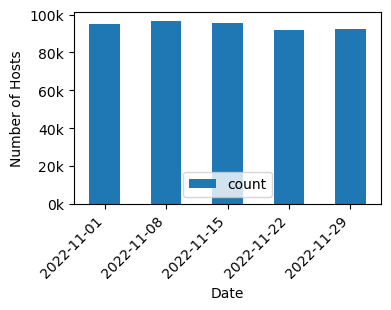

In [74]:
try:
    aggr_ldap_hoster_pdf
except:
    aggr_ldap_hoster_pdf = pd.read_csv("../dataset/censys/processing/censys_date_ldap_hosts.csv", index_col=0, parse_dates=True)

plot = aggr_ldap_hoster_pdf.sort_index()
fig, ax = plt.subplots(figsize=(4,4))  # Adjust the width and height as desired
plot.plot(kind='bar', ax=ax)
plt.tight_layout()
plt.xlabel('Date')
xlabels = [item.strftime('%Y-%m-%d') for item in plot.index]
plt.xticks(range(len(xlabels)), xlabels, rotation=45, ha='right')
# change y ticks to show in k
y, _ = plt.yticks()
ylabels = [f'{item/1000:.0f}k' for item in y]
ax.yaxis.set_ticklabels(ylabels)
ax.set_ylabel('Number of Hosts')
#plt.title('Number of LDAP Hosts')

In [194]:
try:
    aggr_tls_version_pdf
except:
    aggr_tls_version_pdf = pd.read_csv("../dataset/processing/censys_tls_version.csv", index_col=0)
display(aggr_tls_version_pdf)

,count,percentage
tls_version,,
TLSv1_2,90519,64.87
TLSv1_3,42363,30.36
TLSv1_0,5967,4.28
TLSv1_1,682,0.49


In [264]:
try:
    aggr_ciphers_pdf
except:
    aggr_ciphers_pdf = pd.read_csv("../dataset/processing/censys_all_ciphers.csv")

display(aggr_ciphers_pdf)

,tls_cipher,count,percentage
10,TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384,32956,23.62
1,TLS_AES_256_GCM_SHA384,21090,15.11
14,TLS_RSA_WITH_AES_128_GCM_SHA256,18730,13.42
2,TLS_CHACHA20_POLY1305_SHA256,17725,12.70
9,TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA,15481,11.10
8,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,12682,9.09
11,TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256,6166,4.42
13,TLS_RSA_WITH_AES_128_CBC_SHA,5082,3.64
0,TLS_AES_128_GCM_SHA256,3548,2.54
16,TLS_RSA_WITH_AES_256_GCM_SHA384,2643,1.89


In [143]:
# https://owasp.org/www-chapter-london/assets/slides/OWASPLondon20180125_TLSv1.3_Andy_Brodie.pdf
# TLSv1.3:
# key exchange: ECDHE, DHE, PSK and, PSK-DHE (PSK for resumption)
# authentication (digital signature - uses X.509 cert): RSA, EdDSA or ECDSA. (Rivest-Shamir-Addleman, Edwards-curve Digital Signature Algorithm, Elliptic Curve Digital Signature Algorithm)
# See also https://datatracker.ietf.org/doc/html/rfc8446#section-1 for authentication
cipher_mapping = {
    # 'cipher_name' : ('key_exchange', 'authentication', 'encryption', 'hash', 'weak')
    'TLS_CHACHA20_POLY1305_SHA256': ('(EC)DHE/PSK', 'RSA/ECDSA/EdDSA', 'CHACHA20_POLY1305', 'SHA256', False),
    'TLS_AES_256_GCM_SHA384': ('(EC)DHE/PSK','RSA/ECDSA/EdDSA','AES_256_GCM','SHA384', False),
    'TLS_AES_128_GCM_SHA256': ('(EC)DHE/PSK','RSA/ECDSA/EdDSA','AES_128_GCM','SHA256', False),

    'TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256': ('ECDHE','RSA','CHACHA20_POLY1305','SHA256', False),
    'TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256': ('ECDHE','RSA','AES_128_GCM','SHA256', False),
    'TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384': ('ECDHE','RSA','AES_256_GCM','SHA384', False),
    'TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256': ('ECDHE','ECDSA','AES_128_GCM','SHA256', False),
    'TLS_ECDHE_ECDSA_WITH_AES_256_GCM_SHA384': ('ECDHE','ECDSA','AES_256_GCM','SHA384', False),
    'TLS_ECDHE_ECDSA_WITH_CHACHA20_POLY1305_SHA256': ('ECDHE','ECDSA','CHACHA20_POLY1305','SHA256', False),

    'TLS_ECDHE_ECDSA_WITH_AES_128_CBC_SHA': ('ECDHE','ECDSA','AES_128_CBC','SHA', True),
    'TLS_ECDHE_ECDSA_WITH_AES_256_CBC_SHA': ('ECDHE','ECDSA','AES_256_CBC','SHA', True),
    'TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA': ('ECDHE','RSA','AES_256_CBC','SHA', True),
    'TLS_ECDHE_RSA_WITH_AES_128_CBC_SHA': ('ECDHE','RSA','AES_128_CBC','SHA', True),
    'TLS_ECDHE_RSA_WITH_3DES_EDE_CBC_SHA': ('ECDHE','RSA','3DES_EDE_CBC','SHA', True),
    'TLS_RSA_WITH_AES_128_GCM_SHA256': ('RSA','RSA','AES_128_GCM','SHA256', True),
    'TLS_RSA_WITH_AES_256_GCM_SHA384': ('RSA','RSA','AES_256_GCM','SHA384', True),
    'TLS_RSA_WITH_AES_256_CBC_SHA': ('RSA','RSA','AES_256_CBC','SHA', True),
    'TLS_RSA_WITH_AES_128_CBC_SHA': ('RSA','RSA','AES_128_CBC','SHA', True),
    'TLS_RSA_WITH_3DES_EDE_CBC_SHA': ('RSA','RSA','3DES_EDE_CBC','SHA', True),
    # Add more mappings for other non-standard cipher strings if needed
}

def parse_tls_cipher(pdf):
    cipher = pdf['tls_cipher']
    try:
        tls_key_exchange, tls_authentication, tls_encryption, tls_hash, tls_weak = cipher_mapping[cipher]
    except KeyError:
        print(f"Unknown cipher: {cipher}")
        raise
    pdf['cipher_key_exchange'] = tls_key_exchange
    pdf['cipher_authentication'] = tls_authentication
    pdf['cipher_encryption'] = tls_encryption
    pdf['cipher_hash'] = tls_hash
    pdf['cipher_weak'] = tls_weak
    return pdf

In [275]:
def show_cipher_ks(aggr_ciphers_pdf):
    aggr_ciphers_pdf = aggr_ciphers_pdf.apply(parse_tls_cipher, axis=1)
    encryption_pdf = aggr_ciphers_pdf.groupby("cipher_encryption").sum().reset_index().sort_values("count", ascending=False)[["cipher_encryption", "count", "percentage"]]
    display(encryption_pdf)
    key_exchange_pdf = aggr_ciphers_pdf.groupby("cipher_key_exchange").sum().reset_index().sort_values("count", ascending=False)[["cipher_key_exchange", "count", "percentage"]]
    display(key_exchange_pdf)

# TODO call this function with different aggr_ciphers_pdf (censys and goscanner)

,cipher_encryption,count,percentage
4,AES_256_GCM,56821,40.71
2,AES_128_GCM,35022,25.09
5,CHACHA20_POLY1305,24392,17.48
3,AES_256_CBC,16331,11.71
1,AES_128_CBC,6081,4.36
0,3DES_EDE_CBC,884,0.63


,cipher_key_exchange,count,percentage
1,ECDHE,68980,49.44
0,(EC)DHE/PSK,42363,30.35
2,RSA,28188,20.19


In [276]:
try:
    aggr_tls_sign_algo_pdf
except:
    aggr_tls_sign_algo_pdf = pd.read_csv("../dataset/processing/censys_tls_sign_algo.csv")

display(aggr_tls_sign_algo_pdf)

# https://www.alvestrand.no/objectid/submissions/2.16.840.1.101.3.4.3.16.html

,tls_signature_algorithm,count,percentage
7,SHA256-RSA,107810,77.27
6,SHA1-RSA,26698,19.13
9,SHA384-RSA,2081,1.49
10,SHA512-RSA,1278,0.92
5,MD5-RSA,737,0.53
3,ECDSA-SHA384,586,0.42
2,ECDSA-SHA256,287,0.21
8,SHA256-RSAPSS,24,0.02
4,ECDSA-SHA512,20,0.01
0,2.16.840.1.101.3.4.3.16,5,0.00


In [193]:
try:
    aggr_tls_self_signed_pdf
except:
    aggr_tls_self_signed_pdf = pd.read_csv("../dataset/processing/censys_tls_self_signed.csv")


display(aggr_tls_self_signed_pdf)

,count,percentage
tls_signature_self_signed,,
False,108682,77.89
True,30849,22.11


In [249]:
def show_total(aggr_tls_sign_algo_pdf, aggr_ciphers_pdf, aggr_tls_self_signed_pdf, aggr_tls_version_pdf):
    # all should match
    assert aggr_tls_sign_algo_pdf["count"].sum() \
        == aggr_ciphers_pdf["count"].sum() \
        == aggr_tls_self_signed_pdf["count"].sum() \
        == aggr_tls_version_pdf["count"].sum()
    print("Total hosts with TLS: ", aggr_tls_version_pdf["count"].sum())

# TODO call this function with different aggr_*_pdf (censys and goscanner)

Total hosts with TLS:  139531


#### RFC-9325 recommendation - unused

In [197]:
if False:
    aggr_tls_pdf = tls_pdf[["tls_cipher", "tls_version", "pubkey_bit_size"]].groupby(["tls_cipher", "tls_version", "pubkey_bit_size"]).agg('count').reset_index()
    aggr_tls_pdf["rfc9325"] = aggr_tls_pdf.apply(lambda x: rfc9325_recommendation(x['tls_cipher'], x['tls_version'], x['pubkey_bit_size']), axis=1)
    display(aggr_tls_pdf)
    aggr_tls_pdf.to_csv("../dataset/censys/processing/censys_tls.csv")


,tls_cipher,tls_version,pubkey_bit_size,rfc9325
0,TLS_AES_128_GCM_SHA256,TLSv1_3,256,Y
1,TLS_AES_128_GCM_SHA256,TLSv1_3,384,Y
2,TLS_AES_128_GCM_SHA256,TLSv1_3,2048,Y
3,TLS_AES_128_GCM_SHA256,TLSv1_3,4096,Y
4,TLS_AES_256_GCM_SHA384,TLSv1_3,256,Y
...,...,...,...,...
97,TLS_RSA_WITH_AES_256_CBC_SHA,TLSv1_2,4096,N
98,TLS_RSA_WITH_AES_256_GCM_SHA384,TLSv1_2,1024,N
99,TLS_RSA_WITH_AES_256_GCM_SHA384,TLSv1_2,2048,N
100,TLS_RSA_WITH_AES_256_GCM_SHA384,TLSv1_2,3072,N


### DNS - CUIDS only

In [11]:
def get_tld(domain):
    return tldextract.extract(domain).suffix

get_tld_udf = psf.udf(get_tld, StringType())

censys_df.persist()
ldap_dns_df = censys_df.filter((psf.col("dns_name").isNotNull()) & (psf.col("dns_name") != ""))
ldap_dns_df = ldap_dns_df.withColumn("fdns_tlds", get_tld_udf(psf.col("dns_name")))

ldap_dns_pdf = ldap_dns_df.groupBy("fdns_tlds").count().sort(psf.col("count").desc()).toPandas()
total = ldap_dns_pdf["count"].sum()
ldap_dns_pdf["percentage"] = round(ldap_dns_pdf["count"] / total * 100, 2)
ldap_dns_pdf.to_csv("../dataset/processing/censys_ldap_dns.csv")

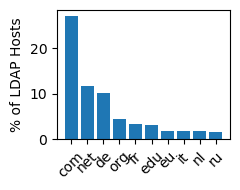

In [153]:
try:
    ldap_dns_pdf
except NameError:
    ldap_dns_pdf = pd.read_csv("../dataset/processing/censys_ldap_dns.csv", index_col=0)

top_tlds = ldap_dns_pdf.head(10)
fig, ax = plt.subplots(figsize=(2.5,2))
ax.set_xticks(range(len(top_tlds["fdns_tlds"])))
ax.set_xticklabels(top_tlds["fdns_tlds"], rotation=45) 
#plt.yticks(rotation=0)
ax.bar(top_tlds['fdns_tlds'], top_tlds['percentage'])
ax.set_ylabel('% of LDAP Hosts')
#ax.set_xlabel('TLD')
#ax.set_title('% of LDAP Hosts\nper TLD - CUIDS')
fig.savefig("output/ldap_tld.pdf", dpi=300, bbox_inches='tight')
fig.show()

### Country & Organizations

In [10]:
# not required
#censys_df.select("ipv4").toPandas().to_csv("../dataset/censys/processing/censys_ldap_ips.csv", index=False)

In [40]:
censys_compact_df.persist()

country_pdf = censys_compact_df.groupBy("country").count().sort(psf.col("count").desc()).toPandas()
total = country_pdf["count"].sum()
country_pdf["percentage"] = round(country_pdf["count"] / total * 100, 2)
country_pdf.to_csv("../dataset/censys/processing/censys_country.csv")

org_pdf = censys_compact_df.groupBy("org").count().sort(psf.col("count").desc()).toPandas()
total = org_pdf["count"].sum()
org_pdf["percentage"] = round(org_pdf["count"] / total * 100, 2)
org_pdf.to_csv("../dataset/censys/processing/censys_org.csv")

censys_compact_df.unpersist()

DataFrame[ipv4: string, dns_names: array<string>, r_dns_names: array<string>, service_names_list: array<string>, port: array<bigint>, tls_version: array<string>, tls_cipher: array<string>, pubkey_bit_size: array<int>, tls_signature_self_signed: array<boolean>, tls_signature_algorithm: array<string>, cert_cn: array<array<string>>, issuer_cn: array<array<string>>, filter_source: string, date: timestamp, country: string, org: string]

In [59]:
try:
    country_pdf
except NameError:
    country_pdf = pd.read_csv("../dataset/censys/processing/censys_country.csv", index_col=0)
try:
    org_pdf
except NameError:
    org_pdf = pd.read_csv("../dataset/censys/processing/censys_org.csv", index_col=0)


# ASN262726 at 20221101 does not give any country nor org name.
# This ASN seems to be http://www.cortezonline.com.br (see https://www.ditatompel.com/asn/262726), https://bgp.he.net/AS262726
# Some IPs do no have ASN
# both cases we classified as Unknown
aggr_country_pdf = country_pdf.groupby("country").sum().reset_index().sort_values("count", ascending=False)
display(aggr_country_pdf[aggr_country_pdf["country"] == "Unknown"])

aggr_org_pdf = org_pdf.groupby("org").sum().reset_index().sort_values("count", ascending=False)
display(aggr_org_pdf[aggr_org_pdf["org"] == "Unknown"])

,country,count,percentage
192,Unknown,118,0.02


,org,count,percentage
9246,Unknown,118,0.02


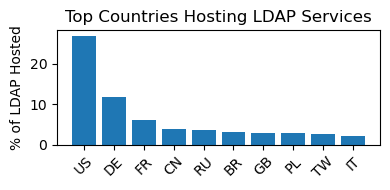

In [143]:
top_country_pdf = country_pdf.head(10)

fig, ax = plt.subplots(figsize=(4,2))
ax.bar(top_country_pdf['country'], top_country_pdf['percentage'])
ax.set_ylabel('% of LDAP Hosted')
#ax.set_xlabel('Country Code')
ax.set_title('Top Countries Hosting LDAP Services')
ax.tick_params(axis='x', rotation=45)
fig.savefig("output/ldap_country.pdf", dpi=300, bbox_inches='tight')
fig.show()

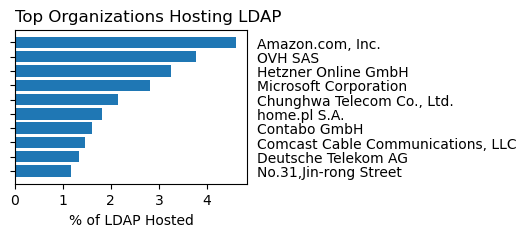

In [140]:
fig, ax = plt.subplots(figsize=(3,2))
top_org_pdf = org_pdf.head(10)
ax.barh(top_org_pdf['org'], top_org_pdf['percentage'])
ax.invert_yaxis() 
ax.set_title('Top Organizations Hosting LDAP', loc='left')
ax.tick_params(axis='y', labelright=True, labelleft=False)  
ax.set_xlabel('% of LDAP Hosted')
fig.set_tight_layout(False)
fig.savefig("output/ldap_org.pdf", dpi=300, bbox_inches='tight')
fig.show()

### Outsourcing analysis

In [21]:
def method_1(leaf_cert_names, rdns_list, fdns_list):
#    varlist = [leaf_cert_names, rdns_list, fdns_list]
#    if rdns_list is not None and len(rdns_list) == 0:
#        x['r_dns_names'] = None
#    if fdns_list is not None and len(fdns_list) == 0:
#        x['dns_names'] = None

    # leaf_cert_names is a list of lists; hence, disentangle it
    flat_leaf_cert_names = []
    for lcn in leaf_cert_names:
        if lcn is not None:
            for name in lcn:
                flat_leaf_cert_names.append(name)

    leaf_cert_set = set(flat_leaf_cert_names) if flat_leaf_cert_names is not None else set()
    rdns_set = set(rdns_list) if rdns_list is not None else set()
    fdns_set = set(fdns_list) if fdns_list is not None else set()

    _x = leaf_cert_set
    _y = rdns_set.union(fdns_set)

    if len(_x) > 0:
        res_set_x = set()
        for item in _x:
            if item is None:
                continue
            extract = tldextract.extract(item)
            domain = extract.domain
            suffix = extract.suffix
            if domain != '' and suffix != '':
                sld_tld = f"{extract.domain}.{extract.suffix}"
                res_set_x.add(sld_tld)
        res_set_x = list(res_set_x) if len(res_set_x) > 0 else None
    else:
        res_set_x = None

    res_set_x = [item.lower() for item in res_set_x] if res_set_x is not None else None
    #x['x_set'] = res_set_x

    if len(_y) > 0:
        res_set_y = set()
        for item in _y:
            if item is None:
                continue
            extract = tldextract.extract(item)
            domain = extract.domain
            suffix = extract.suffix
            if domain != '' and suffix != '':
                sld_tld = f"{extract.domain}.{extract.suffix}"
                res_set_y.add(sld_tld)
        res_set_y = list(res_set_y) if len(res_set_y) > 0 else None
    else:
        res_set_y = None

    res_set_y = [item.lower() for item in res_set_y] if res_set_y is not None else None
    #x['y_set'] = res_set_y

    if res_set_y is not None and res_set_x is not None:
        len_set_x = len(res_set_x)
        counter = 0
        for item in res_set_x:
            if item in res_set_y:
                counter += 1
        outsourced = 'Outsource evidence' if counter != len_set_x else 'No outsource evidence'
        #x['outsourced_a'] = outsourced
    else:
        #x['outsourced_a'] = 'invalid'
        outsourced = 'Invalid'
    return outsourced


method_1_udf = psf.udf(method_1, StringType())

In [22]:
def method_2(rdns_names, fdns_names):
    if rdns_names is None:
        rdns_list = None
    else:
        rdns_set = set()
        for item in rdns_names:
            if item is None:
                continue
            extract = tldextract.extract(item)
            domain = extract.domain
            suffix = extract.suffix
            if domain != '' and suffix != '':
                sld_tld = f"{extract.domain}.{extract.suffix}"
                rdns_set.add(sld_tld)
        rdns_list = list(rdns_set) if len(rdns_set) > 0 else None

    if fdns_names is None:
        fdns_list = None
        fdns_tld_list = None
    else:
        fdns_set = set()
        fdns_tld_set = set()
        for item in fdns_names:
            if item is None:
                continue
            extract = tldextract.extract(item)
            domain = extract.domain
            suffix = extract.suffix
            if domain != '' and suffix != '':
                sld_tld = f"{extract.domain}.{extract.suffix}"
                fdns_set.add(sld_tld)
                fdns_tld_set.add(extract.suffix)
        fdns_list = list(fdns_set) if len(fdns_set) > 0 else None
        fdns_tld_list = list(fdns_tld_set) if len(fdns_tld_set) > 0 else None

    rdns_list = [item.lower() for item in rdns_list] if rdns_list is not None else None
    fdns_list = [item.lower() for item in fdns_list] if fdns_list is not None else None  
    #x['rdns_domains'] = rdns_list # =: x
    #x['fdns_domains'] = fdns_list # =: y
    #x['fdns_tlds'] = fdns_tld_list

    outsourced = 'Invalid'
    if rdns_list is not None and fdns_list is not None:
        target = len(rdns_list)
        counter = 0
        for item in rdns_list:
            if item in fdns_list:
                counter += 1
        if target == counter:
            fdns_list = set(fdns_list)
            rdns_list = set(rdns_list)
            res = fdns_list - rdns_list
            if len(res) > 0:
                #x['outsourced_b'] = True
                outsourced = 'Outsource evidence'
            else:
                #x['outsourced_b'] = False
                outsourced = 'No outsource evidence'
        else:
            #x['outsourced_b'] = True
            outsourced = 'Outsource evidence'
    else:
        #x['outsourced_b'] = 'invalid'
        outsourced = 'Invalid'

    return outsourced


method_2_udf = psf.udf(method_2, StringType())

In [24]:
censys_compact_df = censys_compact_df.withColumn("method_1", method_1_udf(psf.col("leaf_data_names"), psf.col("r_dns_names"), psf.col("dns_names")))
censys_compact_df = censys_compact_df.withColumn("method_2", method_2_udf(psf.col("r_dns_names"), psf.col("dns_names")))

In [36]:
m1_pdf = censys_compact_df.groupBy("method_1").count().to_pandas_on_spark()
m2_pdf = censys_compact_df.groupBy("method_2").count().to_pandas_on_spark()

/usr/local/spark/python/pyspark/sql/dataframe.py:5719: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


In [40]:
print("Applicability")
m1_total = m1_pdf["count"].sum()
m1_pdf["percentage"] = m1_pdf["count"] / m1_total * 100
display(m1_pdf)
m2_total = m2_pdf["count"].sum()
m2_pdf["percentage"] = m2_pdf["count"] / m2_total * 100
display(m2_pdf)
print(m2_total)

assert m1_total == m2_total

Applicability


,method_1,count,percentage
0,Outsource evidence,93587,16.598619
1,No outsource evidence,196812,34.906638
2,Invalid,273425,48.494743


,method_2,count,percentage
0,Outsource evidence,122853,21.789246
1,No outsource evidence,177465,31.475248
2,Invalid,263506,46.735506


563824


#### Outsource with perspective of country

In [103]:
org_country_outsourced_pdf = censys_compact_df.filter((psf.col("method_1") == "Outsource evidence") | (psf.col("method_2") == "Outsource evidence")).groupBy(["org", "country"]).count().sort(psf.col("count").desc()).toPandas()

In [154]:
cc_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in country_pdf.iterrows()]:
    try:
        cc_cnt_dict[item["country"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def country_percentage(country, count):
    if country == "NaN":
        return 0
    return round(count / cc_cnt_dict[country] * 100, 2)

org_country_outsourced_pdf["percentage"] = org_country_outsourced_pdf[["country", "count"]].apply(lambda x: country_percentage(*x), axis=1)
display(org_country_outsourced_pdf.head(10))

,org,country,count,percentage
0,"Amazon.com, Inc.",US,12956,8.55
1,Hetzner Online GmbH,DE,11735,17.73
2,OVH SAS,FR,11437,33.21
3,home.pl S.A.,PL,8755,55.80
4,"Chunghwa Telecom Co., Ltd.",TW,5908,38.72
5,Contabo GmbH,DE,5545,8.38
6,"Comcast Cable Communications, LLC",US,3668,2.42
7,Deutsche Telekom AG,DE,2798,4.23
8,netcup GmbH,DE,2340,3.53
9,Charter Communications Inc,US,2331,1.54


In [207]:
print(cc_cnt_dict["US"], cc_cnt_dict["DE"], cc_cnt_dict["FR"], cc_cnt_dict["PL"], cc_cnt_dict["TW"])

151501 66202 34436 15689 15260


#### Outsourcing combined methods

In [107]:
_outs_censys_df = censys_compact_df.select("org", "tls_version", "tls_cipher", "tls_signature_self_signed", "method_1", "method_2")

In [113]:
df3 = _outs_censys_df.select("org", "method_1", "method_2",
                             psf.explode_outer(psf.arrays_zip(
                                                _outs_censys_df.tls_version,
                                                _outs_censys_df.tls_cipher,
                                                _outs_censys_df.tls_signature_self_signed)))
outs_censys_df = df3.select("org", "method_1", "method_2", "col.tls_version", "col.tls_cipher", "col.tls_signature_self_signed")
outs_censys_df.persist()

##### Oursource and self-signed

In [219]:
# by filtering not null, I'll get different percentages dictionary (see "lookout for discrepancies" below)
outs_censys_df.filter(psf.col("tls_signature_self_signed").isNotNull()) \
              .groupBy(["org", "tls_signature_self_signed"]) \
              .count() \
              .sort(psf.col("count").desc()) \
              .toPandas().to_csv("../dataset/censys/processing/censys_org_ssign.csv")

In [220]:
try:
    org_ssign_pdf
except:
    org_ssign_pdf = pd.read_csv("../dataset/censys/processing/censys_org_ssign.csv", index_col=0)

org_ssign_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in org_ssign_pdf.iterrows()]:
    try:
        org_ssign_cnt_dict[item["org"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def org_ssign_percentage(org, count):
    if not isinstance(org, str) and math.isnan(org):
        return 0
    return round(count / org_ssign_cnt_dict[org] * 100, 2)

org_ssign_pdf["percentage"] = org_ssign_pdf[["org", "count"]].apply(lambda x: org_ssign_percentage(*x), axis=1)
display(org_ssign_pdf[org_ssign_pdf["tls_signature_self_signed"] == True].sort_values("count", ascending=False).head(10))

,org,tls_signature_self_signed,count,percentage
6,OVH SAS,True,22742,23.37
8,"Chunghwa Telecom Co., Ltd.",True,19922,25.78
9,Hetzner Online GmbH,True,17448,17.70
12,Shenzhen Tencent Computer Systems Company Limited,True,15683,86.31
18,Contabo GmbH,True,11616,26.67
21,Microsoft Corporation,True,10267,45.08
24,"Amazon.com, Inc.",True,9506,25.90
25,"No.31,Jin-rong Street",True,9470,47.27
27,Deutsche Telekom AG,True,9096,35.03
29,"Comcast Cable Communications, LLC",True,7997,34.03


##### Data preparation

In [167]:
# TODO
outs_censys_df.filter(psf.col("tls_cipher").isNotNull()) \
              .select(["org", "tls_cipher", "tls_version", "method_1", "method_2"]) \
              .to_pandas_on_spark() \
              .dropna(subset=["tls_cipher"], inplace=True) \
              .apply(parse_tls_cipher, axis=1) \
              .toPandas().to_csv("../dataset/censys/processing/censys_org_tls_outs.csv")

In [168]:
try:
    org_tls_outs_pdf
except:
    org_tls_outs_pdf = pd.read_csv("../dataset/censys/processing/censys_org_tls_outs.csv", index_col=0)

org_tls_outs_pdf.dropna(subset=["tls_cipher"], inplace=True)
org_tls_outs_pdf = org_tls_outs_pdf.apply(parse_tls_cipher, axis=1)

In [170]:
org_tls_outs_pdf.to_csv("../dataset/censys/processing/censys_org_tls_outs.csv")

In [195]:
try:
    org_tls_outs_pdf
except:
    org_tls_outs_pdf = pd.read_csv("../dataset/censys/processing/censys_org_tls_outs.csv", index_col=0)

def combined_methods(method1, method2):
    if method1 == "Outsource evidence" or method2 == "Outsource evidence":
        return True
    return False

def tls_version_weak(tls_version):
    if tls_version == "TLSv1_0" or tls_version == "TLSv1_1":
        return True
    return False

org_tls_outs_pdf["combined"] = org_tls_outs_pdf[['method_1', 'method_2']].apply(lambda x: combined_methods(*x), axis=1)
org_tls_outs_pdf["tls_version_weak"] = org_tls_outs_pdf["tls_version"].apply(tls_version_weak)

In [210]:
aggr_org_outs_pdf = org_tls_outs_pdf.groupby(["org", "combined"]).size().reset_index(name="count").sort_values("count", ascending=False)
org_outs_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in aggr_org_outs_pdf.iterrows()]:
    try:
        org_outs_cnt_dict[item["org"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def org_outs_percentage(org, count):
    if not isinstance(org, str) and math.isnan(org):
        return 0
    return round(count / org_outs_cnt_dict[org] * 100, 2)

aggr_org_outs_pdf["percentage"] = aggr_org_outs_pdf[["org", "count"]].apply(lambda x: org_outs_percentage(*x), axis=1)

In [211]:
display(aggr_org_outs_pdf[aggr_org_outs_pdf["combined"] == True].sort_values("count", ascending=False).head(10))

,org,combined,count,percentage
4343,Hetzner Online GmbH,True,64103,65.04
7603,OVH SAS,True,58673,60.29
12495,home.pl S.A.,True,53235,97.02
1941,"Chunghwa Telecom Co., Ltd.",True,42867,55.47
2269,Contabo GmbH,True,27500,63.13
699,"Amazon.com, Inc.",True,25366,69.11
12579,netcup GmbH,True,13466,73.76
2759,Deutsche Telekom AG,True,13463,51.85
2146,"Comcast Cable Communications, LLC",True,13346,56.79
6087,"Linode, LLC",True,10469,68.36


In [224]:
print(org_outs_cnt_dict["Amazon.com, Inc."], org_outs_cnt_dict["OVH SAS"], org_outs_cnt_dict["Hetzner Online GmbH"])

36706 97321 98558


##### Outsource, weak cipher and weak TLS version

In [200]:
aggr_org_tls_cipher_outs_pdf = org_tls_outs_pdf.groupby(["org", "combined", "cipher_weak", "tls_version_weak"]).size().reset_index(name="count").sort_values("count", ascending=False)
org_tls_cipher_outs_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in aggr_org_tls_cipher_outs_pdf.iterrows()]:
    try:
        org_tls_cipher_outs_cnt_dict[item["org"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def org_tls_cipher_outs_percentage(org, count):
    if not isinstance(org, str) and math.isnan(org):
        return 0
    return round(count / org_tls_cipher_outs_cnt_dict[org] * 100, 2)

aggr_org_tls_cipher_outs_pdf["percentage"] = aggr_org_tls_cipher_outs_pdf[["org", "count"]].apply(lambda x: org_tls_cipher_outs_percentage(*x), axis=1)

In [228]:
tmp = aggr_org_tls_cipher_outs_pdf[(aggr_org_tls_cipher_outs_pdf["combined"] == True) & (aggr_org_tls_cipher_outs_pdf["cipher_weak"] == True) & (aggr_org_tls_cipher_outs_pdf["tls_version_weak"] == True)]
display(tmp[(tmp["org"] == "Amazon.com, Inc.") | (tmp["org"] == "Hetzner Online GmbH") | (tmp["org"] == "OVH SAS")])
display(tmp.sort_values(["count", "percentage"], ascending=False).head(10))

,org,combined,cipher_weak,tls_version_weak,count,percentage
7311,Hetzner Online GmbH,True,True,True,1263,1.28
12760,OVH SAS,True,True,True,1157,1.19
1131,"Amazon.com, Inc.",True,True,True,204,0.56


,org,combined,cipher_weak,tls_version_weak,count,percentage
16402,Six Degrees Technology Group Limited,True,True,True,5150,34.16
3273,"Chunghwa Telecom Co., Ltd.",True,True,True,3155,4.08
3642,"Comcast Cable Communications, LLC",True,True,True,1359,5.78
7311,Hetzner Online GmbH,True,True,True,1263,1.28
1758,"Badger Internet, Inc.",True,True,True,1258,59.90
12760,OVH SAS,True,True,True,1157,1.19
7953,IP worldcom SA,True,True,True,864,41.68
3162,Charter Communications Inc,True,True,True,829,5.02
12318,"No.31,Jin-rong Street",True,True,True,622,3.11
3987,Cox Communications Inc.,True,True,True,467,8.75


##### Outsource and weak cipher

In [ ]:
aggr_org_cipher_outs_pdf = org_tls_outs_pdf.groupby(["org", "combined", "cipher_weak"]).size().reset_index(name="count").sort_values("count", ascending=False)

org_cipher_outs_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in aggr_org_cipher_outs_pdf.iterrows()]:
    try:
        org_cipher_outs_cnt_dict[item["org"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def org_cipher_outs_percentage(org, count):
    if not isinstance(org, str) and math.isnan(org):
        return 0
    return round(count / org_cipher_outs_cnt_dict[org] * 100, 2)

aggr_org_cipher_outs_pdf["percentage"] = aggr_org_cipher_outs_pdf[["org", "count"]].apply(lambda x: org_cipher_outs_percentage(*x), axis=1)

In [185]:
display(aggr_org_cipher_outs_pdf[(aggr_org_cipher_outs_pdf["combined"] == True) & (aggr_org_cipher_outs_pdf["cipher_weak"] == True)].sort_values("count", ascending=False).head(10))

,org,combined,cipher_weak,count,percentage
2942,"Chunghwa Telecom Co., Ltd.",True,True,12368,16.00
11463,OVH SAS,True,True,7389,7.59
14764,Six Degrees Technology Group Limited,True,True,6080,40.33
6569,Hetzner Online GmbH,True,True,5329,5.41
3268,"Comcast Cable Communications, LLC",True,True,4186,17.81
1043,"Amazon.com, Inc.",True,True,3297,8.98
3451,Contabo GmbH,True,True,2824,6.48
2850,Charter Communications Inc,True,True,2229,13.50
1162,Aptum Technologies,True,True,1895,61.09
9995,Microsoft Corporation,True,True,1559,6.85


##### Outsource and weak TLS version

In [196]:
aggr_org_tls_outs_pdf = org_tls_outs_pdf.groupby(["org", "combined", "tls_version_weak"]).size().reset_index(name="count").sort_values("count", ascending=False)

org_tls_outs_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in aggr_org_tls_outs_pdf.iterrows()]:
    try:
        org_tls_outs_cnt_dict[item["org"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def org_tls_outs_percentage(org, count):
    if not isinstance(org, str) and math.isnan(org):
        return 0
    return round(count / org_tls_outs_cnt_dict[org] * 100, 2)

aggr_org_tls_outs_pdf["percentage"] = aggr_org_tls_outs_pdf[["org", "count"]].apply(lambda x: org_tls_outs_percentage(*x), axis=1)

In [230]:
tmp = aggr_org_tls_outs_pdf[(aggr_org_tls_outs_pdf["combined"] == True) & (aggr_org_tls_outs_pdf["tls_version_weak"] == True)]
display(tmp[(tmp["org"] == "Amazon.com, Inc.") | (tmp["org"] == "Hetzner Online GmbH") | (tmp["org"] == "OVH SAS")])
display(tmp.sort_values(["count", "percentage"], ascending=False).head(10))

,org,combined,tls_version_weak,count,percentage
5290,Hetzner Online GmbH,True,True,1263,1.28
9254,OVH SAS,True,True,1157,1.19
818,"Amazon.com, Inc.",True,True,204,0.56


,org,combined,tls_version_weak,count,percentage
11900,Six Degrees Technology Group Limited,True,True,5150,34.16
2360,"Chunghwa Telecom Co., Ltd.",True,True,3155,4.08
2619,"Comcast Cable Communications, LLC",True,True,1359,5.78
5290,Hetzner Online GmbH,True,True,1263,1.28
1284,"Badger Internet, Inc.",True,True,1258,59.90
9254,OVH SAS,True,True,1157,1.19
5750,IP worldcom SA,True,True,864,41.68
2282,Charter Communications Inc,True,True,829,5.02
8931,"No.31,Jin-rong Street",True,True,622,3.11
2868,Cox Communications Inc.,True,True,467,8.75


##### lookout for discrepancies

In [204]:
print(org_tls_outs_cnt_dict == org_ssign_cnt_dict)
print(org_tls_outs_cnt_dict == org_tls_cipher_outs_cnt_dict)
for k,v in org_tls_outs_cnt_dict.items():
    try:
        if v != org_ssign_cnt_dict[k]:
            print(k, v, org_ssign_cnt_dict[k])
    except:
        print(k, v, org_ssign_cnt_dict[k])


False
True
OVH SAS 97321 97316
Amazon.com, Inc. 36706 36699
netcup GmbH 18257 18199
Hostway Deutschland GmbH 270 247
Envia Tel GmbH 179 159
